## Import Packages

In [1]:
# Load libraries
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix

from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

import itertools
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load IRIS dataset

In [2]:
# Load dataset
df = pd.read_csv("iris.csv")
df.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
88,5.6,3.0,4.1,1.3,versicolor
144,6.7,3.3,5.7,2.5,virginica
110,6.5,3.2,5.1,2.0,virginica
120,6.9,3.2,5.7,2.3,virginica
134,6.1,2.6,5.6,1.4,virginica


## Statistical Summary

In [3]:
# Statistics
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


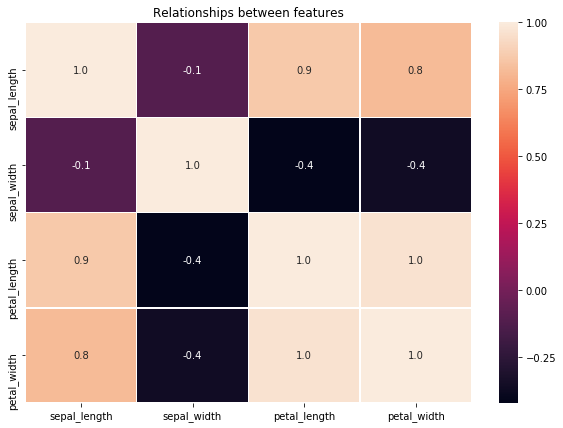

In [4]:
# correlation map to show relationships between features\n",
f,ax = plt.subplots(figsize=(10, 7))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.title("Relationships between features")
plt.show()

## Evaluate Some Algorithms

Now it is time to create some models of the data and estimate their accuracy on unseen data.

Here is what we are going to cover in this step:

1. Separate out a validation dataset.
2. Set-up the test harness to use 10-fold cross validation.
3. Build 5 different models to predict species from flower measurements
4. Select the best model.

### Create a Validation Dataset

In [5]:
# Split-out validation dataset
array = df.values
X = array[:,0:4]
Y = array[:,4]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = \
model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

### Test Harness

In [6]:
# Test options and evaluation metric
seed = 7
scoring = 'accuracy'

### Build Models

Let’s evaluate 6 different algorithms:

- Logistic Regression (LR)
- Linear Discriminant Analysis (LDA)
- K-Nearest Neighbors (KNN).
- Classification and Regression Trees (CART).
- Gaussian Naive Bayes (NB).
- Support Vector Machines (SVM).

In [7]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.966667 (0.040825)
LDA: 0.975000 (0.038188)
KNN: 0.983333 (0.033333)
CART: 0.966667 (0.040825)
NB: 0.975000 (0.053359)
SVM: 0.991667 (0.025000)


### Select Best Model

We now have 6 models and accuracy estimations for each. We need to compare the models to each other and select the most accurate.

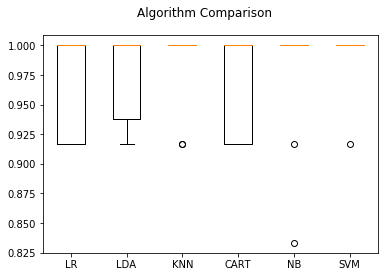

In [8]:
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Make Predictions

The KNN algorithm was the most accurate model that we tested. Let's see the accuracy of the model on our validation set.

This will give us an independent final check on the accuracy of the best model. It is valuable to keep a validation set just in case you made a slip during training, such as overfitting to the training set or a data leak. Both will result in an overly optimistic result.

We can run the KNN model directly on the validation set and summarize the results as a final accuracy score, a confusion matrix and a classification report.

In [9]:
# Make predictions on validation dataset
knn = KNeighborsClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)
class_names = ['setosa', 'versicolor', 'virginica']
cnf_matrix = confusion_matrix(Y_validation, predictions)
print("Accuracy: ", accuracy_score(Y_validation, predictions), "\n")
print('cnf_matrix: \n',cnf_matrix)
print('\nclassification_report\n\n', classification_report(Y_validation, predictions))

Accuracy:  0.9 

cnf_matrix: 
 [[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]

classification_report

              precision    recall  f1-score   support

     setosa       1.00      1.00      1.00         7
 versicolor       0.85      0.92      0.88        12
  virginica       0.90      0.82      0.86        11

avg / total       0.90      0.90      0.90        30



### Visualize confusion matrix

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 7  0  0]
 [ 0 11  1]
 [ 0  2  9]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.91666667 0.08333333]
 [0.         0.18181818 0.81818182]]


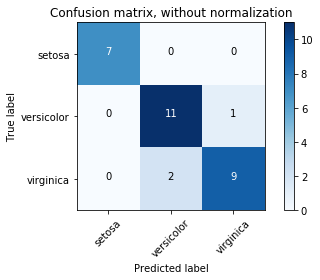

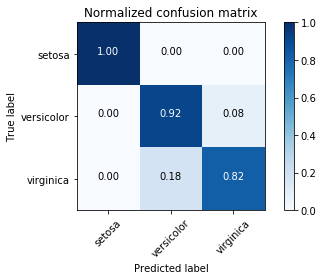

In [11]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()